In [1]:
from obspy import read
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Ruta al archivo .mseed
data_directory = '../../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-01-09HR00_evid00007.mseed'
mseed_file = f'{data_directory}'

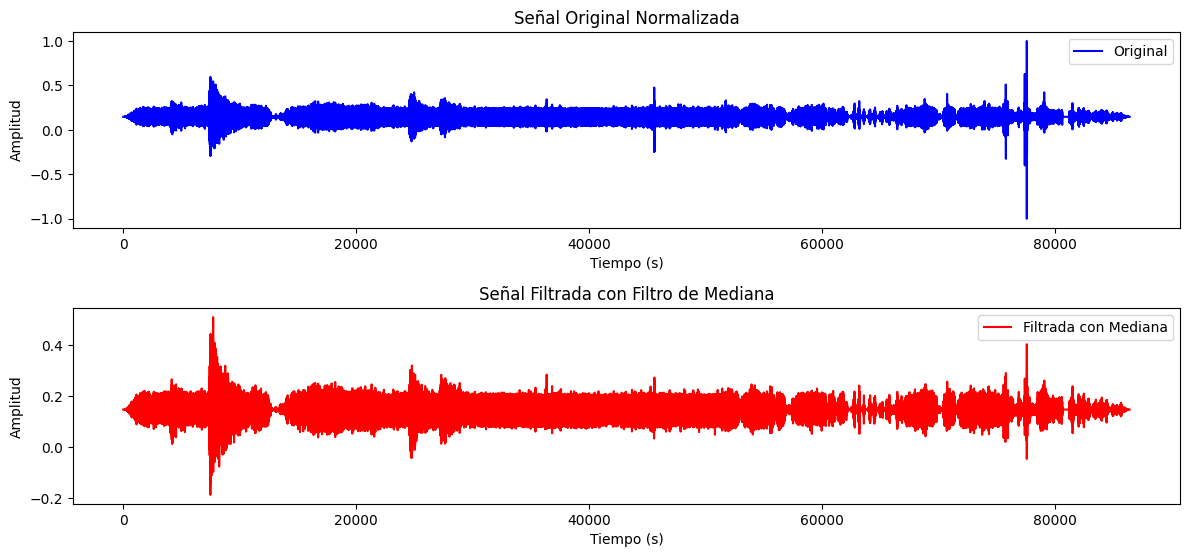

In [3]:
from scipy.signal import medfilt, savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from obspy import read

# Leer el archivo mseed
st = read(mseed_file)
tr = st[0].copy()  # Obtener la primera traza

# Aplicar el filtro de banda
minfreq = 0.5
tr.filter('highpass', freq=minfreq)

# Obtener datos de la traza filtrada
tr_times = tr.times()
tr_data = tr.data

# Normalización Min-Max
min_val = np.min(tr_data)
max_val = np.max(tr_data)
tr_data_minmax = 2 * (tr_data - min_val) / (max_val - min_val) - 1  # Escalado entre -1 y 1

# 1. Aplicar un Filtro de Mediana
tr_data_median_filtered = medfilt(tr_data_minmax, kernel_size=5) 

# Visualizar las señales
plt.figure(figsize=(12, 8))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(tr_times, tr_data_minmax, 'b-', label='Original')
plt.title('Señal Original Normalizada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Señal Filtrada con Mediana
plt.subplot(3, 1, 2)
plt.plot(tr_times, tr_data_median_filtered, 'r-', label='Filtrada con Mediana')
plt.title('Señal Filtrada con Filtro de Mediana')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import noisereduce as nr
sample_rate = 1 / (tr_times[1] - tr_times[0])  # Calcular tasa de muestreo
signal_cleaned = nr.reduce_noise(y=tr_data_median_filtered, sr=sample_rate, time_mask_smooth_ms=40000)

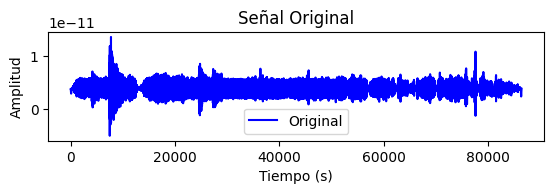

In [5]:
plt.subplot(3, 1, 1)
plt.plot(tr_times, signal_cleaned , 'b-', label='Original')
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

[array([ 6625, 26911], dtype=int64), array([49678, 53648], dtype=int64)]


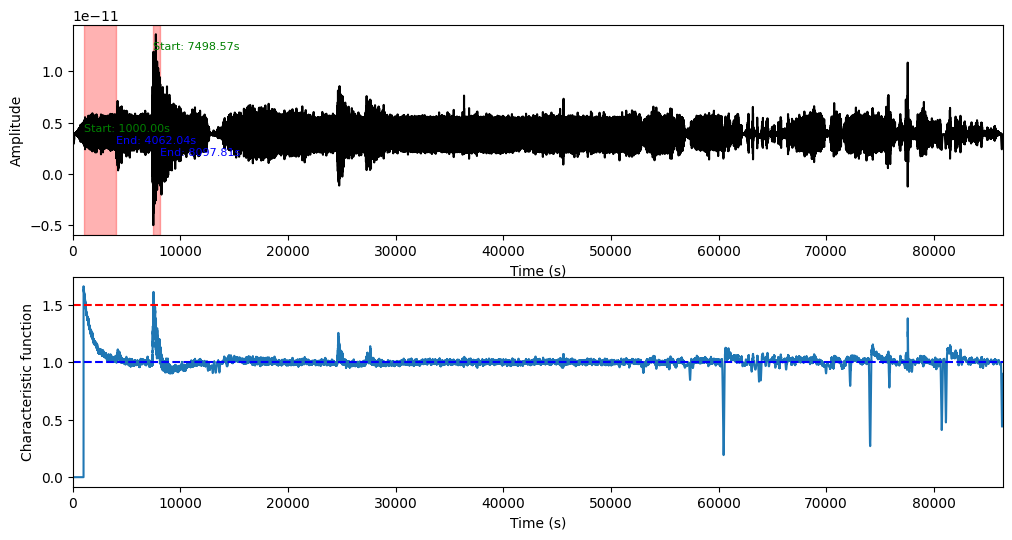

In [16]:
from obspy.signal.trigger import recursive_sta_lta, trigger_onset
import matplotlib.pyplot as plt
import numpy as np
l_threshold_on = [8,4,2,1.8,1.5,1.3,1.15]
l_threshold_off = [2,2,1,1,1,1,0]
merged_on_off = []
x,y = 0,0
while merged_on_off == []:
    df = tr.stats.sampling_rate
    # Aplicar un filtro de banda antes del análisis
    tr.filter('highpass', freq=minfreq)  # Ajustar el filtro de banda

    # Longitudes de ventana STA/LTA en segundos
    sta_len = 20#60  # Ventana de corto plazo
    lta_len = 1000#1800  # Ventana de largo plazo

    # Ejecutar STA/LTA recursivo
    cft = recursive_sta_lta( signal_cleaned, int(sta_len * df), int(lta_len * df))

    cft_smoothed = medfilt(cft, kernel_size=5)

    # Definir umbrales para la detección (ajustados)
    threshold_on = l_threshold_on[x] # Incrementar umbral de activación
    threshold_off = l_threshold_off[y] # Incrementar umbral de desactivación

    # Detectar eventos
    on_off = trigger_onset(cft_smoothed, threshold_on, threshold_off)

    # Filtrar detecciones cortas (menos de 60 segundos)
    min_duration = 360 * df
    on_off_filtered = [event for event in on_off if (event[1] - event[0]) > min_duration]

    # Fusionar detecciones cercanas (si la diferencia entre ellas es menor a un cierto tiempo)
    min_gap = 5000  # Número de muestras entre eventos detectados para fusionarlos
    merged_on_off = []
    if len(on_off_filtered) > 0:
        current_event = on_off_filtered[0]
        for i in range(1, len(on_off_filtered)):
            if on_off_filtered[i][0] - current_event[1] < min_gap:
                current_event[1] = on_off_filtered[i][1]  # Fusionar eventos
            else:
                merged_on_off.append(current_event)
                current_event = on_off_filtered[i]
        merged_on_off.append(current_event)
    x+=1
    y+=1
#Visualizar la función característica y las detecciones
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Gráfico de la señal con detecciones
ax[0].plot(tr.times(),  signal_cleaned  , 'k')  # Usar la señal normalizada
for start, end in merged_on_off:
    # Convertir índices a tiempo en segundos
    start_time = start / df
    end_time = end / df
    
    # Resaltar el intervalo detectado
    ax[0].axvspan(tr.times()[start], tr.times()[end], color='red', alpha=0.3)
    
    # Anotar el tiempo de inicio y fin
    ax[0].text(tr.times()[start],  signal_cleaned[start], f'Start: {start_time:.2f}s', color='green', fontsize=8, verticalalignment='bottom')
    ax[0].text(tr.times()[end],  signal_cleaned[end], f'End: {end_time:.2f}s', color='blue', fontsize=8, verticalalignment='top')

ax[0].set_xlim([min(tr.times()), max(tr.times())])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# Gráfico de la función característica STA/LTA
ax[1].plot(tr.times(), cft_smoothed)
ax[1].axhline(y=threshold_on, color='r', linestyle='--')
ax[1].axhline(y=threshold_off, color='b', linestyle='--')
ax[1].set_xlim([min(tr.times()), max(tr.times())])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Characteristic function')
print(merged_on_off)

Text(0, 0.5, 'Characteristic function')

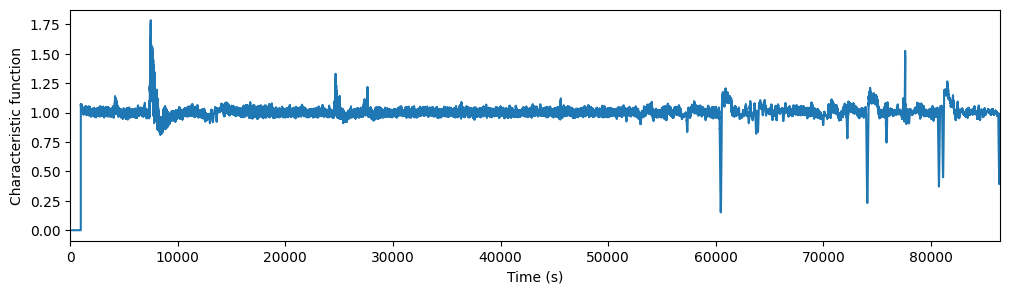

In [18]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 20
lta_len = 1000

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(signal_cleaned, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

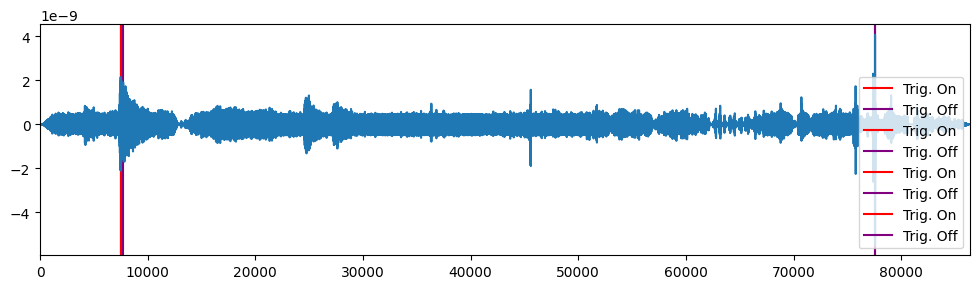

In [19]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 1.50
thr_off = 1.25
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()